# H1C IDR3.2 RFI

In [1]:
import os
import h5py
import numpy as np
from scipy import signal

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import rfi
from library import cptools as cp

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# configure matplotlib
mpl.style.use("classic")

## Load Data
Load closure phases. Meta data is printed below cell.

In [13]:
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2.h5"

with h5py.File(path, "r") as f:
    jd = f["JD"][()]
    lst = f["LST"][()]
    bispec = f["bispec"][()]
    rfiflags = f["RFI"][()]
    flags = f["flags"][()]

# generate frequency array
frqrange = [152.25, 167.97]
fmin, fmax, fN = (100, 200, 1024)
df = (fmax - fmin) / fN
frq = np.arange(frqrange[0], frqrange[1], df)

# time data
lstmin, lstmax, lstN = np.min(lst), np.max(lst), len(lst)
dt = (lstmax - lstmin) * 3600 / lstN

print(f"data has shape {bispec.shape}")
print(f"JD range {min(jd)}-{max(jd)}, {len(jd)} nights")
print(r"LST range {:.2f}-{:.2f} h, integration time {:.2f} s".format(lstmin, lstmax, dt))
print(r"frequency range {:.2f}-{:.2f} MHz, channel width {:.4f} MHz".format(min(frq), max(frq), df))

data has shape (2, 150, 95, 752, 161)
JD range 2458033-2458193, 150 nights
LST range 4.00-6.25 h, integration time 10.75 s
frequency range 152.25-167.88 MHz, channel width 0.0977 MHz


## Apply Flags and Remove NaN-only Data

In [14]:
bispec[flags] = np.nan
badjd = np.all(np.isnan(bispec), axis=(0, 2, 3, 4))
bispec = bispec[:, ~badjd]
rfiflags = rfiflags[~badjd]
jd = jd[~badjd]
print(f"data has shape {bispec.shape}")

data has shape (2, 82, 95, 752, 161)


## Average Polarisations and Triads

In [5]:
bispecRFI = np.nanmean(bispec, axis=(0, 2))

## Average JDs

In [18]:
mbispec = cp.geomed(bispecRFI, axis=0)
print(f"data has shape {mbispec.shape}")

data has shape (752, 161)


## RFI metric

In [19]:
res = np.abs(np.angle(bispecRFI * mbispec.conjugate()))
z = res / (1.4826 * np.nanmedian(res, axis=0))

## Median Detrend and RFI metric

In [18]:
import imp; imp.reload(rfi)
bispecF = rfi.moving_median_2D(bispec, axes=(1, 2))
mad = 1.4826 * rfi.moving_median_2D(np.abs(bispec - bispecF), axes=(1, 2))

In [6]:
z = np.abs(bispec - bispecF) / mad

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [94]:
for i in range(10):
    z_t = np.nanmean(z, axis=-1)
    z_t = np.moveaxis(z_t, -1, 0) / (np.nanmedian(z_t, axis=-1))
    z_t = np.moveaxis(z_t, 0, -1)
    idx = np.where(z_t > 1.20)
    z[idx[0], idx[1]] = np.nan

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [33]:
flags = np.zeros_like(z).astype(bool)

for i in range(z.shape[0]):
    flags[i][np.where((z[i]>4) | ((z[i]>2) & rfi.nbr_idx_2D(z[i]>4)))] = True
    
    for j in range(z.shape[1]):
        if flags[i, j].sum() / flags.shape[-1] > 0.1:
            flags[i, j] = True

In [26]:
bispecRFI[rfiflags] = np.nan

In [32]:
data_f = rfi.poly_2D_fit(bispecRFI[21], 72, 16)
data_v = 1.4826 * rfi.moving_median_2D(np.abs(bispecRFI[21] - data_f), K=(8, 8), axes=(0, 1))
res = np.abs(bispecRFI[21] - data_f)
z = res / data_v

In [33]:
zt = np.nanmean(z, axis=-1)
zt = zt - np.nanmedian(zt)
zt = zt / (1.4826 * np.nanmedian(np.abs(zt)))

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(0, 10)

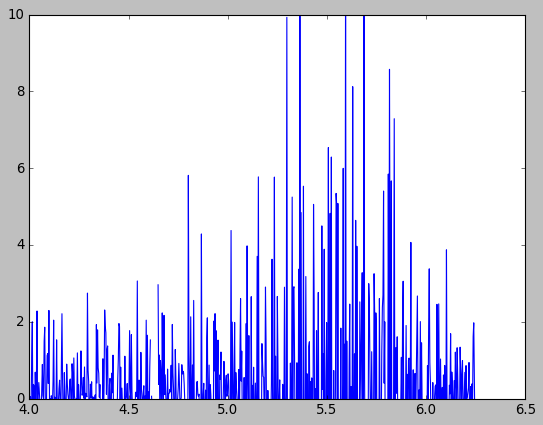

In [34]:
plt.plot(np.flip(lst), zt)
plt.ylim([0, 10])


## Plot

In [15]:
z = rfiflags.sum(axis=-1) / rfiflags.shape[-1]
for i in range(z.shape[0]):
    rfiflags[i][np.where((z[i] > 0.2) | ((z[i] > 0.1) & rfi.nbr_idx_1D(z[i] > 0.2)))] = True

In [27]:
def plot(j):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    
    im1 = ax[0].imshow(
        np.angle(bispecRFI[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
        vmin = -np.pi,
        vmax = np.pi,
    )
    im2 = ax[1].imshow(
        rfiflags[j],
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.bone,
        interpolation="None",
        aspect="auto",
        vmin=0, 
        vmax=1,
    )

    ax[0].set_title(f"JD {jd[j]}, Bispectrum Phase")
    ax[1].set_title(f"JD {jd[j]}, Bispectrum Flags")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, len(jd)-1, 1))

interactive(children=(IntSlider(value=40, description='j', max=81), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(j)>

In [48]:
import imp; imp.reload(rfi)
flags = np.zeros_like(z).astype(bool)

for j in range(1):
    print(j)
    zm = 4
    while zm > 3:
        idx = np.unravel_index(np.nanargmax(z[j]), np.array(z[j]).shape)
        zm = z[j][idx]
        bispec[j][idx] = np.nan
        imin, jmin = max(0, idx[0] - 8), max(0, idx[1] - 8)
        imax, jmax = min(z.shape[-2], idx[0] + 8), min(z.shape[-1], idx[1] + 8)
        s1 = slice(imin, imax)
        s2 = slice(jmin, jmax)
        irange = ((imin, imax), (jmin, jmax))
        bispecF[j, s1, s2] = rfi.moving_median_2D(bispec[j], irange=irange, axes=(0, 1))
        mad[j, s1, s2] = 1.4826 * rfi.moving_median_2D(np.abs(bispec[j] - bispecF[j]), irange=irange, axes=(0, 1))
        z[j] = np.abs(bispec[j] - bispecF[j]) / mad[j]

flags[np.where(np.isnan(bispec))] = True

0


## Median over JD
Need this for RFI metric.

In [418]:
mbispec = cp.geomed(bispec, axis=0)
print(f"data has shape {mbispec.shape}")

data has shape (752, 161)


## High-Pass Filter

In [419]:
def wfilter(data, w, axis):
    ft = np.fft.fft(data, axis=axis)
    ft = np.moveaxis(ft, axis, -1)
    ft = ft * np.fft.fftshift(w)
    ift = np.fft.ifft(ft, axis=-1)
    return np.moveaxis(ift, -1, axis)

In [420]:
N = 20
w = np.zeros(bispec.shape[-1])
s = slice(w.size // 2 - N, w.size // 2 + N)
bw = signal.blackmanharris(w.shape[-1])
w[s] = signal.tukey(w[s].size, alpha=0.1)
eicp = np.exp(1j * np.angle(bispec))
eicpF = wfilter(eicp, w, axis=-1)

N = 60
w = np.zeros(bispec.shape[-2])
s = slice(w.size // 2 - N, w.size // 2 + N)
bw = signal.blackmanharris(w.shape[-1])
w[s] = signal.tukey(w[s].size, alpha=0.1)
eicpF = wfilter(eicpF, w, axis=-2)

## RFI Metric

In [449]:
dphase = np.abs(np.angle(eicpF*eicp.conjugate()))
sig = 1.4826 * np.nanmedian(dphase)
z = dphase / sig

## Plot

In [428]:
def plot(j):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    im1 = ax[0].imshow(
        np.angle(bispec[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )
    im2 = ax[1].imshow(
        np.abs(bispec[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.bone,
        interpolation="None",
        aspect="auto",
        vmin=0, 
        vmax=1e-4,
    )
    
    ax[0].set_title(f"JD {jd[j]}, Bispectrum Phase")
    ax[1].set_title(f"JD {jd[j]}, Bispectrum Amplitude")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, len(jd)-1, 1))

interactive(children=(IntSlider(value=40, description='j', max=81), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(j)>

In [460]:
def plot(j):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    im1 = ax[0].imshow(
        (eicp[j]-eicpF[j]).imag,
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
    )
    im2 = ax[1].imshow(
        np.abs(z[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.bone,
        interpolation="None",
        aspect="auto",
        vmin=0, 
        vmax=100,
    )
    
    ax[0].set_title(f"JD {jd[j]}, Bispectrum Phase")
    ax[1].set_title(f"JD {jd[j]}, RFI Metric")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, len(jd)-1, 1))

interactive(children=(IntSlider(value=40, description='j', max=81), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(j)>

In [430]:
def wfilter(data, w, axis):
    ft = np.fft.fft(data, axis=axis)
    ft = np.moveaxis(ft, axis, -1)
    ft = ft * np.fft.fftshift(w)
    ift = np.fft.ifft(ft, axis=-1)
    return np.moveaxis(ift, -1, axis)

In [389]:
N = 20
w = np.zeros(mbispec.shape[-1])
s = slice(w.size // 2 - N, w.size // 2 + N)
bw = signal.blackmanharris(w.shape[-1])
w[s] = signal.tukey(w[s].size, alpha=0.1)
eicp = np.exp(1j * np.angle(bispec))
eicpF = wfilter(eicp, w, axis=-1)
bispecF = wfilter(bispec, w, axis=-1)

N = 60
w = np.zeros(mbispec.shape[-2])
s = slice(w.size // 2 - N, w.size // 2 + N)
bw = signal.blackmanharris(w.shape[-1])
w[s] = signal.tukey(w[s].size, alpha=0.1)
eicpF = wfilter(eicpF, w, axis=-2)

In [390]:
def plot(j):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    im1 = ax[0].imshow(
        np.angle(eicpF[j]*eicp[j].conjugate()),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
        vmin=-np.pi/2,
        vmax=np.pi/2,
    )
    im2 = ax[1].imshow(
        np.abs(bispec[j]) - np.abs(bispecF[j]),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.bone,
        interpolation="None",
        aspect="auto",
        vmin=0, 
        vmax=1e-4,
    )
    
    ax[0].set_title(f"JD {jd[j]}, Bispectrum Phase")
    ax[1].set_title(f"JD {jd[j]}, Bispectrum Amplitude")
    plt.setp(ax, xlabel="Frequency (MHz)", ylabel="LST (h)", ylim=[min(lst), max(lst)])
    
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, len(jd)-1, 1))

interactive(children=(IntSlider(value=40, description='j', max=81), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(j)>